In [1]:
# This code needs to be retrofitted with Olist data 
# if we want to integrate the customer segmentation part
# as derived feature engineering

**This notebook shows how we can create the customer segementation. One of the recommendation technique (matrix factorisation) using collaboration filtering is coded as a sample using the data. However, it's commented out as we are planning to implement a more sophisticated approach using a variant of DCN V2. It may act as baseline though.**

Initial setup for Keras

In [ ]:
# !pip install pytorch_accelerated

In [ ]:
# !pip install torchmetrics

In [ ]:
# pip install --upgrade keras

Data (https://www.kaggle.com/datasets/darpan25bajaj/retail-case-study-data/data)

Motivation (https://taufik-azri.medium.com/recommendation-system-for-retail-customer-3f0f80b84221)

In [ ]:
import pandas as pd

customer = pd.read_csv("Customer.csv")

customer.head()

,customer_Id,DOB,Gender,city_code
0,268408,02-01-1970,M,4.0
1,269696,07-01-1970,F,8.0
2,268159,08-01-1970,F,8.0
3,270181,10-01-1970,F,2.0
4,268073,11-01-1970,M,1.0


In [ ]:
transaction = pd.read_csv("Transactions.csv")

transaction.head()

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type
0,80712190438,270351,28-02-2014,1,1,-5,-772,405.300,-4265.300,e-Shop
1,29258453508,270384,27-02-2014,5,3,-5,-1497,785.925,-8270.925,e-Shop
2,51750724947,273420,24-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop
3,93274880719,271509,24-02-2014,11,6,-3,-1363,429.345,-4518.345,e-Shop
4,51750724947,273420,23-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop


In [ ]:
product = pd.read_csv("prod_cat_info.csv")

product.head()

,prod_cat_code,prod_cat,prod_sub_cat_code,prod_subcat
0,1,Clothing,4,Mens
1,1,Clothing,1,Women
2,1,Clothing,3,Kids
3,2,Footwear,1,Mens
4,2,Footwear,3,Women


LRFMV (https://www.researchgate.net/publication/366454878_LRFMV_An_efficient_customer_segmentation_model_for_superstores)



In [ ]:
transaction["tran_date"] = pd.to_datetime(transaction['tran_date'])

length = transaction.groupby('cust_id').agg(
    last_purchase_date=('tran_date', 'max'),
    first_purchase_date=('tran_date', 'min')
    ).assign(
        length=lambda x: (x['last_purchase_date'] - x['first_purchase_date']).dt.days
        ).reset_index()

length

<ipython-input-7-cd08f4064c03>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  transaction["tran_date"] = pd.to_datetime(transaction['tran_date'])


,cust_id,last_purchase_date,first_purchase_date,length
0,266783,2013-09-02,2011-09-23,710
1,266784,2012-09-09,2012-04-12,150
2,266785,2013-02-13,2011-03-15,701
3,266788,2013-12-02,2011-09-13,811
4,266794,2014-12-02,2011-03-18,1355
...,...,...,...,...
5501,275257,2013-03-09,2011-05-12,667
5502,275261,2013-06-27,2011-05-10,779
5503,275262,2012-02-29,2011-08-13,200
5504,275264,2011-08-10,2011-05-08,94


In [ ]:
max_date = transaction.tran_date.max()
print(max_date)

recency = transaction.groupby('cust_id').agg(
    last_purchase_date=('tran_date', 'max')
    ).assign(
        recency=lambda x: (max_date - x['last_purchase_date']).dt.days
        ).reset_index()

recency

2014-12-02 00:00:00


,cust_id,last_purchase_date,recency
0,266783,2013-09-02,456
1,266784,2012-09-09,814
2,266785,2013-02-13,657
3,266788,2013-12-02,365
4,266794,2014-12-02,0
...,...,...,...
5501,275257,2013-03-09,633
5502,275261,2013-06-27,523
5503,275262,2012-02-29,1007
5504,275264,2011-08-10,1210


In [ ]:
frequency = transaction.groupby('cust_id').agg(
    frequency=('transaction_id', 'count')
).reset_index()

frequency

,cust_id,frequency
0,266783,5
1,266784,3
2,266785,8
3,266788,4
4,266794,12
...,...,...
5501,275257,5
5502,275261,5
5503,275262,2
5504,275264,2


In [ ]:
monetary = transaction.groupby('cust_id').agg(
    transaction_count=('transaction_id', 'count'),
    total_spend=('total_amt', 'sum')
).assign(
    monetary=lambda x: round(x['total_spend'] / x['transaction_count'], 2)
).reset_index()

monetary

,cust_id,transaction_count,total_spend,monetary
0,266783,5,3113.890,622.78
1,266784,3,5694.065,1898.02
2,266785,8,21613.800,2701.72
3,266788,4,6092.970,1523.24
4,266794,12,27981.915,2331.83
...,...,...,...,...
5501,275257,5,12574.900,2514.98
5502,275261,5,442.000,88.40
5503,275262,2,5078.580,2539.29
5504,275264,2,3815.565,1907.78


In [ ]:
quantity_per_day = transaction.groupby(['cust_id', 'tran_date']).agg(
    total_quantity=('Qty', 'sum'),
    transaction_count=('transaction_id', 'count')
).assign(
    qty_per_day=lambda x: x['total_quantity'] / x['transaction_count']
).reset_index()

quantity_per_day

,cust_id,tran_date,total_quantity,transaction_count,qty_per_day
0,266783,2011-09-23,4,1,4.0
1,266783,2011-09-24,-4,1,-4.0
2,266783,2012-10-21,3,1,3.0
3,266783,2013-02-20,1,1,1.0
4,266783,2013-09-02,2,1,2.0
...,...,...,...,...,...
22996,275264,2011-05-08,5,1,5.0
22997,275264,2011-08-10,4,1,4.0
22998,275265,2011-12-17,1,1,1.0
22999,275265,2011-12-26,3,1,3.0


In [ ]:
volume = quantity_per_day.groupby('cust_id').agg(
    num_days=('tran_date', 'count'),
    total_qty_per_day = ('qty_per_day', 'sum')
).assign(
    volume=lambda x: round(x['total_qty_per_day'] / x['num_days'], 2)
).reset_index()

volume

,cust_id,num_days,total_qty_per_day,volume
0,266783,5,6.0,1.20
1,266784,3,10.0,3.33
2,266785,8,23.0,2.88
3,266788,4,8.0,2.00
4,266794,11,26.5,2.41
...,...,...,...,...
5501,275257,5,9.0,1.80
5502,275261,5,5.0,1.00
5503,275262,2,5.0,2.50
5504,275264,2,9.0,4.50


In [ ]:
lrfmv = pd.merge(
    pd.merge(
        pd.merge(
            pd.merge(
                length, recency, on="cust_id"
                ), frequency, on="cust_id"
                ), monetary, on="cust_id"
                ), volume, on="cust_id"
                )[["cust_id",
                   "length",
                   "recency",
                   "frequency",
                   "monetary",
                   "volume"]]

lrfmv

,cust_id,length,recency,frequency,monetary,volume
0,266783,710,456,5,622.78,1.20
1,266784,150,814,3,1898.02,3.33
2,266785,701,657,8,2701.72,2.88
3,266788,811,365,4,1523.24,2.00
4,266794,1355,0,12,2331.83,2.41
...,...,...,...,...,...,...
5501,275257,667,633,5,2514.98,1.80
5502,275261,779,523,5,88.40,1.00
5503,275262,200,1007,2,2539.29,2.50
5504,275264,94,1210,2,1907.78,4.50


Silhouette coefficient

PCA

Best Cluster = 2: Silhouette Score = 0.27683265010541636


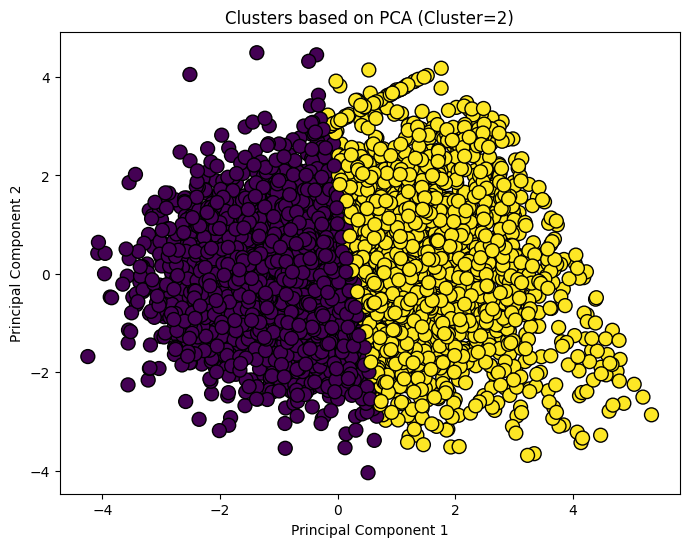

,cust_id,cluster
0,273463,0
1,268647,1
2,273734,0
3,275151,0
4,272636,0
...,...,...
5501,272602,1
5502,274806,1
5503,274853,0
5504,275090,0


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

random_seed = 42

X = lrfmv[["length", "recency", "frequency", "monetary", "volume"]]

scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)
X_standardized_df = pd.DataFrame(X_standardized, columns=X.columns)
X_standardized_df["cust_id"] = lrfmv["cust_id"]
X_standardized_df_shuffled = X_standardized_df.sample(frac=1, random_state=random_seed).reset_index(drop=True)

cust_id_column = X_standardized_df_shuffled["cust_id"]
X_standardized_df_shuffled = X_standardized_df_shuffled.drop(columns=["cust_id"])

best_score = float('-inf')

for i in range(2, 10):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=random_seed, n_init="auto")
    score = silhouette_score(X_standardized_df_shuffled, kmeans.fit_predict(X_standardized_df_shuffled))
    if score > best_score:
        best_score = score
        best_cluster = i

print(f"Best Cluster = {best_cluster}: Silhouette Score = {best_score}")

kmeans = KMeans(n_clusters=best_cluster, init='k-means++', random_state=random_seed, n_init="auto")
X_standardized_df_shuffled["cluster"] = kmeans.fit_predict(X_standardized_df_shuffled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_standardized_df_shuffled.iloc[:, :-1])

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=X_standardized_df_shuffled["cluster"], cmap='viridis', edgecolor='k', s=100)
plt.title(f'Clusters based on PCA (Cluster={best_cluster})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

X_standardized_df_shuffled["cust_id"] = cust_id_column
X_standardized_df_shuffled[["cust_id", "cluster"]]

Cluster specific plot

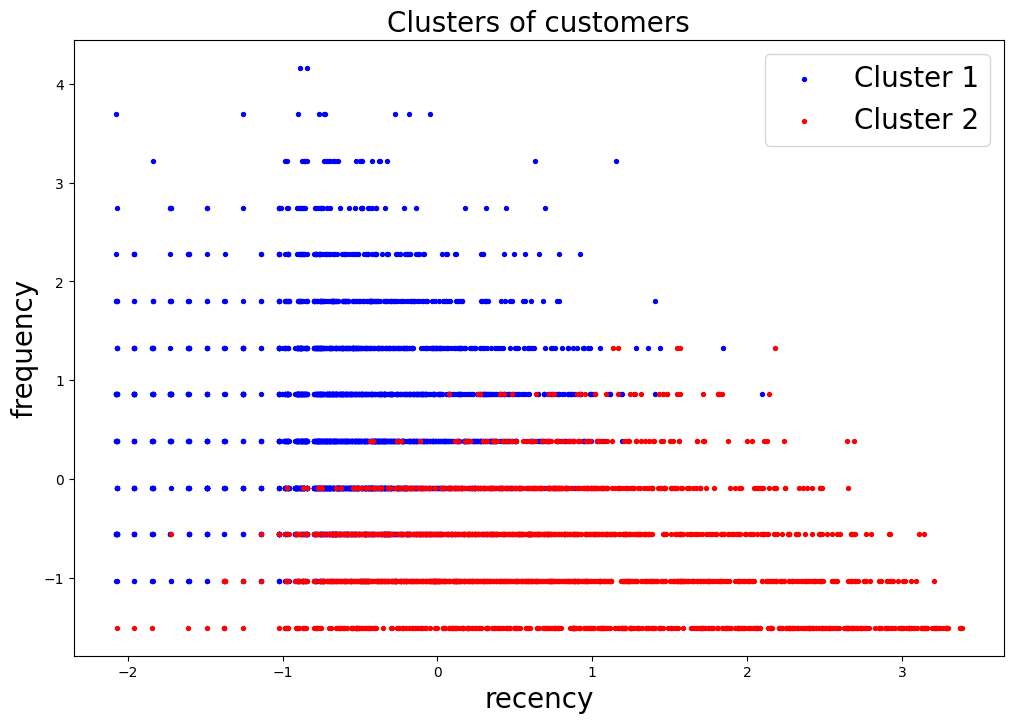

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

var1 = 'recency'
var2 = 'frequency'
temp = X_standardized_df_shuffled.copy()

c1 = temp[temp.cluster == 0]
c2 = temp[temp.cluster == 1]

plt.scatter(c1[var1], c1[var2], c = 'b', label = 'Cluster 1', s=8)
plt.scatter(c2[var1], c2[var2], c = 'r', label = 'Cluster 2', s=8)

plt.title('Clusters of customers', size=20)
plt.xlabel(var1, size=20)
plt.ylabel(var2, size=20)
plt.legend(fontsize=20)

Matrix Factorisation as baseline

In [ ]:
# transaction.head()

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type
0,80712190438,270351,2014-02-28,1,1,-5,-772,405.300,-4265.300,e-Shop
1,29258453508,270384,2014-02-27,5,3,-5,-1497,785.925,-8270.925,e-Shop
2,51750724947,273420,2014-02-24,6,5,-2,-791,166.110,-1748.110,TeleShop
3,93274880719,271509,2014-02-24,11,6,-3,-1363,429.345,-4518.345,e-Shop
4,51750724947,273420,2014-02-23,6,5,-2,-791,166.110,-1748.110,TeleShop


In [ ]:
# transaction["product_id"] = transaction['prod_cat_code'].astype(str) + '_' + transaction['prod_subcat_code'].astype(str) + '_' + transaction['Store_type']
# transaction.head()

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type,product_id
0,80712190438,270351,2014-02-28,1,1,-5,-772,405.300,-4265.300,e-Shop,1_1_e-Shop
1,29258453508,270384,2014-02-27,5,3,-5,-1497,785.925,-8270.925,e-Shop,3_5_e-Shop
2,51750724947,273420,2014-02-24,6,5,-2,-791,166.110,-1748.110,TeleShop,5_6_TeleShop
3,93274880719,271509,2014-02-24,11,6,-3,-1363,429.345,-4518.345,e-Shop,6_11_e-Shop
4,51750724947,273420,2014-02-23,6,5,-2,-791,166.110,-1748.110,TeleShop,5_6_TeleShop


Keras implementation - https://keras.io/examples/structured_data/collaborative_filtering_movielens/

In [ ]:
# import numpy as np
# from sklearn.preprocessing import MinMaxScaler

# cust_ids = transaction["cust_id"].unique().tolist()
# cust2cust_encoded = {x: i for i, x in enumerate(cust_ids)}
# cust_encoded2cust = {i: x for i, x in enumerate(cust_ids)}

# product_ids = transaction["product_id"].unique().tolist()
# product2product_encoded = {x: i for i, x in enumerate(product_ids)}
# product_encoded2product = {i: x for i, x in enumerate(product_ids)}

# transaction["cust"] = transaction["cust_id"].map(cust2cust_encoded)
# transaction["product"] = transaction["product_id"].map(product2product_encoded)

# num_cust = len(cust2cust_encoded)
# num_product = len(product2product_encoded)
# df = transaction[["cust", "product", "Qty"]].groupby(["cust", "product"]).sum().reset_index()
# df["Qty"] = df["Qty"].values.astype(np.float32)
# df['Qty'] = MinMaxScaler().fit_transform(df[['Qty']])

# min_qty = min(df["Qty"])
# max_qty = max(df["Qty"])

# print(
#     "Number of customers: {}, Number of products: {}, Min quantity: {}, Max quantity: {}".format(
#         num_cust, num_product, min_qty, max_qty
#     )
# )

Number of customers: 5506, Number of products: 92, Min quantity: 0.0, Max quantity: 1.0


In [ ]:
# df.head()

,cust,product,Qty
0,0,0,0.50
1,0,7,0.65
2,0,9,0.55
3,0,25,0.65
4,1,1,0.50


In [ ]:
# df = df.sample(frac=1, random_state=42)
# x = df[["cust", "product"]].values

# y = df["Qty"].values

# train_indices = int(0.8 * df.shape[0])
# x_train, x_val, y_train, y_val = (
#     x[:train_indices],
#     x[train_indices:],
#     y[:train_indices],
#     y[train_indices:],
# )

In [ ]:
# import keras
# from keras import layers
# from keras import ops

In [ ]:
# EMBEDDING_SIZE = 50

# class RecommenderNet(keras.Model):
#     def __init__(self, num_cust, num_product, embedding_size, **kwargs):
#         super().__init__(**kwargs)

#         self.num_cust = num_cust
#         self.num_product = num_product
#         self.embedding_size = embedding_size

#         self.masking_layer = layers.Masking(mask_value=0, name="masking")
#         self.embedding_dropout = layers.Dropout(0.2, name="dropout")

#         self.cust_embedding = layers.Embedding(
#             num_cust,
#             embedding_size,
#             embeddings_initializer="glorot_uniform",
#             embeddings_regularizer=keras.regularizers.l2(1e-6),
#             name="cust_embedding"
#         )
#         self.cust_bias = layers.Embedding(num_cust, 1, name="cust_bias")

#         self.product_embedding = layers.Embedding(
#             num_product,
#             embedding_size,
#             embeddings_initializer="glorot_uniform",
#             embeddings_regularizer=keras.regularizers.l2(1e-6),
#             name="product_embedding"
#         )
#         self.product_bias = layers.Embedding(num_product, 1, name="product_bias")

#     def call(self, inputs):
#         inputs = self.masking_layer(inputs)
#         inputs = self.embedding_dropout(inputs)

#         cust_vector = self.cust_embedding(inputs[:, 0])
#         cust_bias = self.cust_bias(inputs[:, 0])

#         product_vector = self.product_embedding(inputs[:, 1])
#         product_bias = self.product_bias(inputs[:, 1])

#         dot_cust_product = ops.tensordot(cust_vector, product_vector, 2)

#         x = dot_cust_product + cust_bias + product_bias

#         return ops.nn.sigmoid(x)


# model = RecommenderNet(num_cust, num_product, EMBEDDING_SIZE, name="MatFactRecNet")
# model.compile(
#     loss=keras.losses.MeanSquaredError(),
#     optimizer=keras.optimizers.Adam(learning_rate=0.001),
# )
# model.summary()

Model: "MatFactRecNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ masking (Masking)                  │ ?                             │ 0 (unbuilt) │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout (Dropout)                  │ ?                             │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ cust_embedding (Embedding)         │ ?                             │ 0 (unbuilt) │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ cust_bias (Embedding)              │ ?                             │ 0 (unbuilt) │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ product_embedding (Embedding)      │ ?                             │ 0 (unbuilt) │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ product_bias (Embedding)           │ ?                             │ 0 (unbuilt) │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# checkpoint = keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
# history = model.fit(
#     x=x_train,
#     y=y_train,
#     batch_size=32,
#     epochs=30,
#     verbose=1,
#     validation_data=(x_val, y_val),
#     callbacks=[early_stopping, checkpoint]
# )

Epoch 1/30
506/510 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0227
Epoch 1: val_loss improved from inf to 0.01069, saving model to best_model.keras
510/510 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0226 - val_loss: 0.0107
Epoch 2/30
508/510 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0361
Epoch 2: val_loss did not improve from 0.01069
510/510 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0360 - val_loss: 0.0223
Epoch 3/30
500/510 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0103
Epoch 3: val_loss did not improve from 0.01069
510/510 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0103 - val_loss: 0.0158
Epoch 4/30
499/510 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0083
Epoch 4: val_loss did not improve from 0.01069
510/510 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0083 - val_loss: 0.0186
Epoch 5/30
504/510 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0073
Epoch 5: val_loss did not improve from 0.01069
510/510 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0073 - val_loss: 0.0168
Epoch 6/30
504/510

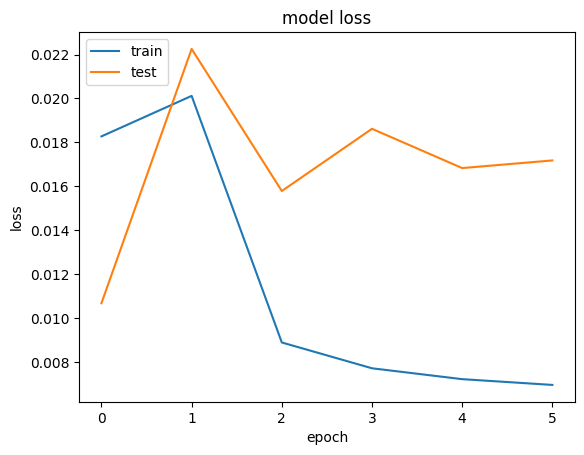

In [ ]:
# plt.plot(history.history["loss"])
# plt.plot(history.history["val_loss"])
# plt.title("model loss")
# plt.ylabel("loss")
# plt.xlabel("epoch")
# plt.legend(["train", "test"], loc="upper left")
# plt.show()

In [ ]:
# cust_id = transaction.cust_id.sample(1).iloc[0]
# product_bought_by_cust = transaction[transaction.cust_id == cust_id]
# product_not_bought = [i for i in product_ids if i not in product_bought_by_cust.product_id.values]
# product_not_bought = list(
#     set(product_not_bought).intersection(set(product2product_encoded.keys()))
# )
# product_not_bought = [[product2product_encoded.get(x)] for x in product_not_bought]
# cust_encoder = cust2cust_encoded.get(cust_id)
# cust_product_array = np.hstack(
#     ([[cust_encoder]] * len(product_not_bought), product_not_bought)
# )
# Qty = model.predict(cust_product_array).flatten()
# top_product_indices = Qty.argsort()[-10:][::-1]
# recommended_product_ids = [
#     product_encoded2product.get(product_not_bought[x][0]) for x in top_product_indices
# ]

# print("Showing recommendations for customer: {}".format(cust_id))
# print("====" * 9)
# print("Products bought by customer")
# print("----" * 8)
# for row in set(product_bought_by_cust.product_id.values):
#     print(row)

# print("----" * 8)
# print("Top 10 product recommendations")
# print("----" * 8)
# for row in recommended_product_ids:
#     print(row)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Showing recommendations for customer: 273038
Products bought by customer
--------------------------------
2_1_e-Shop
2_4_Flagship store
6_11_TeleShop
6_10_Flagship store
5_7_Flagship store
--------------------------------
Top 10 product recommendations
--------------------------------
5_7_e-Shop
5_6_e-Shop
6_2_e-Shop
5_12_e-Shop
5_11_e-Shop
5_10_e-Shop
3_4_Flagship store
3_4_e-Shop
1_4_e-Shop
3_10_TeleShop


In [ ]:
# product_id = transaction.product_id.sample(1).iloc[0]
# customers_who_bought_product = transaction[transaction.product_id == product_id]
# customers_not_bought = [i for i in cust_ids if i not in customers_who_bought_product.cust_id.values]
# customers_not_bought = list(
#     set(customers_not_bought).intersection(set(cust2cust_encoded.keys()))
# )
# customers_not_bought = [[cust2cust_encoded.get(x)] for x in customers_not_bought]
# product_encoder = product2product_encoded.get(product_id)
# product_customer_array = np.hstack(
#     ([[product_encoder]] * len(customers_not_bought), customers_not_bought)
# )
# Qty = model.predict(product_customer_array).flatten()
# top_customer_indices = Qty.argsort()[-10:][::-1]
# recommended_customer_ids = [
#     cust_encoded2cust.get(customers_not_bought[x][0]) for x in top_customer_indices
# ]

# print("Showing recommendations for product: {}".format(product_id))
# print("====" * 9)
# print("Customers who bought the product")
# print("----" * 8)
# for row in set(customers_who_bought_product.cust_id.values):
#     print(row)

# print("----" * 8)
# print("Top 10 customer recommendations")
# print("----" * 8)
# for row in recommended_customer_ids:
#     print(row)

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Showing recommendations for product: 3_10_MBR
Customers who bought the product
--------------------------------
269825
271364
269318
274955
273421
270864
267794
269844
268825
272922
267801
272415
272416
271905
269859
269860
269861
273444
274471
273972
272437
274486
266807
270905
270908
266815
269894
266824
275016
270923
268876
271950
273486
270414
268372
273495
272473
272993
270433
271460
269413
271978
273518
268402
268915
266867
271986
272506
271995
266875
270462
269952
267906
266883
269447
268938
269451
270476
269457
270998
267419
274589
270496
268282
270502
272559
270003
273076
269491
269495
270519
269503
274115
273091
267463
273096
273610
272075
272589
268494
267983
274128
271063
272088
273625
270042
270555
266972
274138
270039
267482
268514
269546
268523
267500
272622
273135
271599
271601
270066
272626
271092
275190
269559
268535
266998
269050
268538
274689
271620
270597
267528
270093
275225
275227
268575
272676
274728
272684
270125
268589


BST - Transformer based recommendation

Motivation (https://keras.io/examples/structured_data/movielens_recommendations_transformers/)

In [ ]:
# df = transaction[["cust", "product", "Qty", "tran_date"]].groupby(["cust", "product", "tran_date"]).sum().reset_index()
# df

In [ ]:
# df_group = df.sort_values(by=["tran_date"]).groupby("cust")

# df_data = pd.DataFrame(
#     data={
#         "cust_id": list(df_group.groups.keys()),
#         "product_ids": list(df_group.product.apply(list)),
#         "Qtys": list(df_group.Qty.apply(list)),
#         "tran_dates": list(df_group.tran_date.apply(list)),
#     }
# )
# df_data

In [ ]:
# sequence_length = 4
# step_size = 2


# def create_sequences(values, window_size, step_size):
#     sequences = []
#     start_index = 0
#     while True:
#         end_index = start_index + window_size
#         seq = values[start_index:end_index]
#         if len(seq) < window_size:
#             seq = values[-window_size:]
#             if len(seq) == window_size:
#                 sequences.append(seq)
#             break
#         sequences.append(seq)
#         start_index += step_size
#     return sequences


# df_data.product_ids = df_data.product_ids.apply(
#     lambda ids: create_sequences(ids, sequence_length, step_size)
# )

# df_data.Qtys = df_data.Qtys.apply(
#     lambda ids: create_sequences(ids, sequence_length, step_size)
# )

# del df_data["tran_dates"]
# df_data[df_data["cust_id"]==0]

In [ ]:
# df_data_product = df_data[["cust_id", "product_ids"]].explode(
#     "product_ids", ignore_index=True
# )
# df_data_Qty = df_data[["Qtys"]].explode("Qtys", ignore_index=True)

# df_data_transformed = pd.concat([df_data_product, df_data_Qty], axis=1)
# df_data_transformed.product_ids = df_data_transformed.product_ids.apply(
#     lambda x: ",".join(map(str, x)) if hasattr(x, '__iter__') else str(x)
# )
# df_data_transformed.Qtys = df_data_transformed.Qtys.apply(
#     lambda x: ",".join(map(str, x)) if hasattr(x, '__iter__') else str(x)
# )
# df_data_transformed.rename(
#     columns={"product_ids": "sequence_product_ids", "Qtys": "sequence_Qtys"},
#     inplace=True,
# )
# df_data_transformed

In [ ]:
# random_selection = np.random.rand(len(df_data_transformed.index)) <= 0.8
# train_data = df_data_transformed[random_selection]
# test_data = df_data_transformed[~random_selection]

# train_data.to_csv("train_data.csv", index=False, sep="|", header=False)
# test_data.to_csv("test_data.csv", index=False, sep="|", header=False)

In [ ]:
# CSV_HEADER = list(df_data_transformed.columns)

# CATEGORICAL_FEATURES_WITH_VOCABULARY = {
#     "cust_id": list(df["cust"].unique()),
#     "product_id": list(df["product"].unique()),
# }

Motivation (https://medium.com/data-science-at-microsoft/comparing-matrix-factorization-with-transformers-for-movielens-recommendations-using-8e3cd3ec8bd8)

In [ ]:
# from sklearn.preprocessing import MinMaxScaler

# df = transaction[["cust", "product", "Qty", "tran_date"]].groupby(["cust", "product", "tran_date"]).sum().reset_index()
# df['product'] = df['product'].astype(str)
# df["Qty"] = df["Qty"].values.astype(np.float32)
# df['Qty'] = MinMaxScaler().fit_transform(df[['Qty']])
# df

,cust,product,tran_date,Qty
0,0,0,2014-02-20,1.000000
1,0,0,2014-02-28,0.333333
2,0,7,2013-03-18,0.866667
3,0,9,2011-12-13,0.733333
4,0,25,2013-09-16,0.866667
...,...,...,...,...
23035,5501,62,2011-01-31,0.866667
23036,5502,47,2011-01-30,0.933333
23037,5503,36,2011-01-29,0.866667
23038,5504,74,2011-01-29,0.933333


In [ ]:
# def get_last_n_qty_by_cust(
#     df, n, min_qty_per_cust=1, cust_colname="cust", date_colname="tran_date"
# ):
#     return (
#         df.groupby(cust_colname)
#         .filter(lambda x: len(x) >= min_qty_per_cust)
#         .sort_values(date_colname)
#         .groupby(cust_colname)
#         .tail(n)
#         .sort_values(cust_colname)
#     )

# def mark_last_n_qty_as_validation_set(
#     df, n, min_qty=1, cust_colname="cust", date_colname="tran_date"
# ):
#     df["is_val"] = False
#     df.loc[
#         get_last_n_qty_by_cust(
#             df,
#             n,
#             min_qty,
#             cust_colname=cust_colname,
#             date_colname=date_colname,
#         ).index,
#         "is_val",
#     ] = True

#     return df

In [ ]:
# mark_last_n_qty_as_validation_set(df, 1)

,cust,product,tran_date,Qty,is_val
0,0,0,2014-02-20,1.000000,False
1,0,0,2014-02-28,0.333333,True
2,0,7,2013-03-18,0.866667,False
3,0,9,2011-12-13,0.733333,False
4,0,25,2013-09-16,0.866667,False
...,...,...,...,...,...
23035,5501,62,2011-01-31,0.866667,True
23036,5502,47,2011-01-30,0.933333,True
23037,5503,36,2011-01-29,0.866667,True
23038,5504,74,2011-01-29,0.933333,True


In [ ]:
# train_df = df[df.is_val==False]
# val_df = df[df.is_val==True]
# train_df.shape,  val_df.shape

((17534, 5), (5506, 5))

New Baseline

In [ ]:
# median_Qty = train_df.Qty.median()
# median_Qty

0.8666667

In [ ]:
# import math
# from sklearn.metrics import mean_squared_error, mean_absolute_error

# predictions = np.array([median_Qty]* len(val_df))

# mae = mean_absolute_error(val_df.Qty, predictions)
# mse = mean_squared_error(val_df.Qty, predictions)
# rmse = math.sqrt(mse)

# print(f'mae: {mae}')
# print(f'mse: {mse}')
# print(f'rmse: {rmse}')

mae: 0.10601768642663956
mse: 0.022047866135835648
rmse: 0.14848523878094969


New Matrix Factorisation

In [ ]:
# cust_lookup = {v: i+1 for i, v in enumerate(df['cust'].unique())}
# product_lookup = {v: i+1 for i, v in enumerate(df['product'].unique())}

In [ ]:
# import torch
# from torch.utils.data import Dataset

# class CustProductQtyDataset(Dataset):
#     def __init__(self, df, product_lookup, cust_lookup):
#         self.df = df
#         self.product_lookup = product_lookup
#         self.cust_lookup = cust_lookup

#     def __getitem__(self, index):
#         row = self.df.iloc[index]
#         cust_id = self.cust_lookup[row["cust"]]
#         product_id = self.product_lookup[row["product"]]

#         Qty = torch.tensor(row["Qty"], dtype=torch.float32)

#         return (cust_id, product_id), Qty

#     def __len__(self):
#         return len(self.df)

In [ ]:
# mf_train_df = train_df.groupby(["cust", "product", "is_val"]).sum(["Qty"]).reset_index()
# mf_val_df = val_df.groupby(["cust", "product", "is_val"]).sum(["Qty"]).reset_index()

In [ ]:
# mf_train_df.Qty.min(), mf_train_df.Qty.max()

(0.0, 3.1333334)

In [ ]:
# mf_val_df.Qty.min(), mf_val_df.Qty.max()

(0.0, 1.0)

In [ ]:
# train_dataset = CustProductQtyDataset(mf_train_df, product_lookup, cust_lookup)
# val_dataset = CustProductQtyDataset(mf_val_df, product_lookup, cust_lookup)

In [ ]:
# import torch
# from torch import nn

# class MfDotBias(nn.Module):

#     def __init__(
#         self, n_factors, n_cust, n_product, Qty_range=None, use_biases=True
#     ):
#         super().__init__()
#         self.bias = use_biases
#         self.y_range = Qty_range
#         self.cust_embedding = nn.Embedding(n_cust+1, n_factors, padding_idx=0)
#         self.product_embedding = nn.Embedding(n_product+1, n_factors, padding_idx=0)

#         if use_biases:
#             self.cust_bias = nn.Embedding(n_cust+1, 1, padding_idx=0)
#             self.product_bias = nn.Embedding(n_product+1, 1, padding_idx=0)

#     def forward(self, inputs):
#         cust, product = inputs
#         dot = self.cust_embedding(cust) * self.product_embedding(product)
#         result = dot.sum(1)
#         if self.bias:
#             result = (
#                 result + self.cust_bias(cust).squeeze() + self.product_bias(product).squeeze()
#             )

#         if self.y_range is None:
#             return result
#         else:
#             return (
#                 torch.sigmoid(result) * (self.y_range[1] - self.y_range[0])
#                 + self.y_range[0]
#             )

In [ ]:
# from functools import partial

# from pytorch_accelerated import Trainer, notebook_launcher
# from pytorch_accelerated.trainer import TrainerPlaceholderValues, DEFAULT_CALLBACKS
# from pytorch_accelerated.callbacks import EarlyStoppingCallback, SaveBestModelCallback, TrainerCallback, StopTrainingError
# import torchmetrics

INFO:pytorch_accelerated:Setting random seeds


In [ ]:
# class RecommenderMetricsCallback(TrainerCallback):
#     def __init__(self):
#         self.metrics = torchmetrics.MetricCollection(
#             {
#                 "mse": torchmetrics.MeanSquaredError(),
#                 "mae": torchmetrics.MeanAbsoluteError(),
#             }
#         )

#     def _move_to_device(self, trainer):
#         self.metrics.to(trainer.device)

#     def on_training_run_start(self, trainer, **kwargs):
#         self._move_to_device(trainer)

#     def on_evaluation_run_start(self, trainer, **kwargs):
#         self._move_to_device(trainer)

#     def on_eval_step_end(self, trainer, batch, batch_output, **kwargs):
#         preds = batch_output["model_outputs"]
#         self.metrics.update(preds, batch[1])

#     def on_eval_epoch_end(self, trainer, **kwargs):
#         metrics = self.metrics.compute()

#         mse = metrics["mse"].cpu()
#         trainer.run_history.update_metric("mae", metrics["mae"].cpu())
#         trainer.run_history.update_metric("mse", mse)
#         trainer.run_history.update_metric("rmse",  math.sqrt(mse))

#         self.metrics.reset()

In [ ]:
# def train_mf_model():
#     model = MfDotBias(
#         120, len(cust_lookup), len(product_lookup), Qty_range=[0.0, 1.0]
#     )
#     loss_func = torch.nn.MSELoss()

#     optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

#     create_sched_fn = partial(
#         torch.optim.lr_scheduler.OneCycleLR,
#         max_lr=0.01,
#         epochs=TrainerPlaceholderValues.NUM_EPOCHS,
#         steps_per_epoch=TrainerPlaceholderValues.NUM_UPDATE_STEPS_PER_EPOCH,
#     )

#     trainer = Trainer(
#         model=model,
#         loss_func=loss_func,
#         optimizer=optimizer,
#         callbacks=(
#             RecommenderMetricsCallback,
#             *DEFAULT_CALLBACKS,
#             SaveBestModelCallback(watch_metric="mae"),
#             EarlyStoppingCallback(
#                 early_stopping_patience=2,
#                 early_stopping_threshold=0.001,
#                 watch_metric="mae",
#             ),
#         ),
#     )

#     trainer.train(
#         train_dataset=train_dataset,
#         eval_dataset=val_dataset,
#         num_epochs=30,
#         per_device_batch_size=512,
#         create_scheduler_fn=create_sched_fn,
#     )

In [ ]:
# notebook_launcher(train_mf_model, num_processes=2)

Launching training on one CPU.

Starting training run

Starting epoch 1


100%|██████████| 31/31 [00:04<00:00,  7.44it/s]



train_loss_epoch: 0.43661242723464966


100%|██████████| 11/11 [00:01<00:00,  8.42it/s]



eval_loss_epoch: 0.3441413640975952

mae: 0.4708898067474365

rmse: 0.5866356314592519

mse: 0.3441413640975952

Starting epoch 2


100%|██████████| 31/31 [00:02<00:00, 12.36it/s]



train_loss_epoch: 0.4242544174194336


100%|██████████| 11/11 [00:00<00:00, 14.84it/s]



eval_loss_epoch: 0.34311190247535706

mae: 0.4698839783668518

rmse: 0.585757571250837

mse: 0.34311193227767944

Improvement of 0.0010058283805847168 observed, resetting counter. 
Early stopping counter: 0/2

Starting epoch 3


100%|██████████| 31/31 [00:02<00:00, 14.44it/s]



train_loss_epoch: 0.4001576602458954


100%|██████████| 11/11 [00:00<00:00, 14.13it/s]



eval_loss_epoch: 0.34082096815109253

mae: 0.46757495403289795

rmse: 0.5837987394223223

mse: 0.34082096815109253

Improvement of 0.0023090243339538574 observed, resetting counter. 
Early stopping counter: 0/2

Starting epoch 4


100%|██████████| 31/31 [00:03<00:00, 10.22it/s]



train_loss_epoch: 0.3577486276626587


100%|██████████| 11/11 [00:00<00:00, 14.25it/s]



eval_loss_epoch: 0.3372347950935364

mae: 0.46417179703712463

rmse: 0.5807192050324635

mse: 0.3372347950935364

Improvement of 0.0034031569957733154 observed, resetting counter. 
Early stopping counter: 0/2

Starting epoch 5


100%|██████████| 31/31 [00:02<00:00, 14.52it/s]



train_loss_epoch: 0.30503684282302856


100%|██████████| 11/11 [00:00<00:00, 14.95it/s]



eval_loss_epoch: 0.33551710844039917

mae: 0.46232038736343384

rmse: 0.5792384122645196

mse: 0.33551713824272156

Improvement of 0.001851409673690796 observed, resetting counter. 
Early stopping counter: 0/2

Starting epoch 6


100%|██████████| 31/31 [00:02<00:00, 14.47it/s]



train_loss_epoch: 0.270082026720047


100%|██████████| 11/11 [00:00<00:00, 14.78it/s]



eval_loss_epoch: 0.33498328924179077

mae: 0.4618152678012848

rmse: 0.5787773575712392

mse: 0.334983229637146
No improvement above threshold observed, incrementing counter. 
Early stopping counter: 1/2

Starting epoch 7


100%|██████████| 31/31 [00:02<00:00, 14.54it/s]



train_loss_epoch: 0.25036779046058655


100%|██████████| 11/11 [00:00<00:00, 14.37it/s]



eval_loss_epoch: 0.33319607377052307

mae: 0.4603303372859955

rmse: 0.5772313866817388

mse: 0.33319607377052307

Improvement of 0.0019900500774383545 observed, resetting counter. 
Early stopping counter: 0/2

Starting epoch 8


100%|██████████| 31/31 [00:02<00:00, 10.75it/s]



train_loss_epoch: 0.23968924582004547


100%|██████████| 11/11 [00:00<00:00, 12.70it/s]



eval_loss_epoch: 0.33321571350097656

mae: 0.4602768123149872

rmse: 0.5772483984395076

mse: 0.33321571350097656
No improvement above threshold observed, incrementing counter. 
Early stopping counter: 1/2

Starting epoch 9


100%|██████████| 31/31 [00:02<00:00, 14.50it/s]



train_loss_epoch: 0.22985361516475677


100%|██████████| 11/11 [00:00<00:00, 14.48it/s]



eval_loss_epoch: 0.33157360553741455

mae: 0.4589838981628418

rmse: 0.5758242835600237

mse: 0.33157360553741455

Improvement of 0.0013464391231536865 observed, resetting counter. 
Early stopping counter: 0/2

Starting epoch 10


100%|██████████| 31/31 [00:03<00:00, 10.22it/s]



train_loss_epoch: 0.22335228323936462


100%|██████████| 11/11 [00:00<00:00, 14.65it/s]



eval_loss_epoch: 0.3302011489868164

mae: 0.4577002227306366

rmse: 0.5746313416349119

mse: 0.3302011787891388

Improvement of 0.0012836754322052002 observed, resetting counter. 
Early stopping counter: 0/2

Starting epoch 11


100%|██████████| 31/31 [00:02<00:00, 14.94it/s]



train_loss_epoch: 0.21716345846652985


100%|██████████| 11/11 [00:00<00:00, 11.93it/s]



eval_loss_epoch: 0.32995131611824036

mae: 0.4575778841972351

rmse: 0.574413915152273

mse: 0.32995134592056274
No improvement above threshold observed, incrementing counter. 
Early stopping counter: 1/2

Starting epoch 12


100%|██████████| 31/31 [00:02<00:00, 11.09it/s]



train_loss_epoch: 0.21248166263103485


100%|██████████| 11/11 [00:00<00:00, 14.84it/s]


eval_loss_epoch: 0.32986894249916077

mae: 0.45756053924560547

rmse: 0.5743421824132029

mse: 0.32986894249916077
No improvement above threshold observed, incrementing counter. 
Early stopping counter: 2/2
Stopping training due to no improvement after 2 epochs
Finishing training run
Loading checkpoint with mae: 0.45756053924560547 from epoch 12
